<a href="https://colab.research.google.com/github/fernandasica/tcc/blob/main/chap3/tsi_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
#pip install pvlib

In [295]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


import itertools
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3


In [296]:
# Funções

def e0(x):
    # Variação da distância entre a Terra e o Sol
    return (1.000110 + 0.034221 * np.cos(x) + 0.001280 * np.sin(x) + 0.000719 * np.cos(2 * x) + 0.000077 * np.sin(2 * x))

def delta(x):
    # Declinação solar
    return (0.006918 - 0.399912 * np.cos(x) + 0.070257 * np.sin(x) - 0.006758 * np.cos(2 * x) + 0.000907 * np.sin(2 * x) - 0.002697 * np.cos(3 * x) + 0.001480 * np.sin(3 * x))

def Et(x):
    # Equação do tempo
    return (0.000075 + 0.001868 * np.cos(x) - 0.032077 * np.sin(x) - 0.014615 * np.cos(2 * x) - 0.04089 * np.sin(2 * x))


In [297]:
# Coordenadas da Localização (Torre Meteorológica FURG)
# Latitude: 32°04'10.7''S
# Longitude: 52°10'8.2''W

# Convertendo a latitude para graus decimais
phi = -32 - (4 / 60) - (10.7 / 3600)

# Convertendo a longitude para graus decimais
lon = -52 - (10 / 60) - (8.2 / 3600)

# Meridiano padrão -45
corr = np.radians(lon - -45) # -7.169
fuso = -3 + corr*12/np.pi

loc = Location(phi, lon, tz='UTC', altitude=2, name='Torre Meteorológica FURG')

print(loc)

Location: 
  name: Torre Meteorológica FURG
  latitude: -32.06963888888889
  longitude: -52.16894444444444
  altitude: 2
  tz: UTC


In [298]:
# Construindo array de tempo para o período de estudo
# conforme calendário disponível em: https://www.esrl.noaa.gov/gmd/grad/neubrew/Calendar.jsp


# Dias
d_nov = np.arange(20, 31) # Dias de novembro (324-334)
d_dec = np.arange(1, 32)  # Dias de dezembro (335-365)
to_remove = [3, 19, 30]   # Dias faltantes (338, 353, 364)
d_dec = np.delete(d_dec, np.where(np.isin(d_dec, to_remove)))  # Removendo dias faltantes
d_data = np.concatenate((d_nov, d_dec))  # Unindo dias de novembro e dezembro

# Meses
m_nov = np.full(len(d_nov), 11)  # Mês de novembro (11)
m_dec = np.full(len(d_dec), 12)  # Mês de dezembro (12)
m_data = np.concatenate((m_nov, m_dec)) # Unindo meses de novembro e dezembro
print(d_data, m_data, len(m_data))


[20 21 22 23 24 25 26 27 28 29 30  1  2  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 20 21 22 23 24 25 26 27 28 29 31] [11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12] 39


In [299]:
sc = 1361.1  # Constante Solar revisada

def converter_hora_decimal(hora_decimal):
    horas = int(hora_decimal)
    minutos_decimal = (hora_decimal - horas) * 60
    minutos = int(minutos_decimal)
    segundos_decimal = (minutos_decimal - minutos) * 60
    segundos = int(segundos_decimal)

    return horas, minutos, segundos


def times(alvor, poer, x,m):
  horas, minutos, segundos = converter_hora_decimal(alvor)
  hora , minuto , segundo  = converter_hora_decimal(poer)
  start = pd.Timestamp(f'2014-{int(m):02d}-{int(x):02d} {horas:02d}:{minutos:02d}:{segundos:02d}')
  end   = pd.Timestamp(f'2014-{int(m):02d}-{int(x):02d} {hora:02d}:{minuto:02d}:{segundo:02d}' )
  times = pd.date_range(start=start, end=end, freq='S')

  return times

In [300]:
print(f'phi: {np.radians(phi):.3f} lon: {np.radians(lon):.3f}')

phi: -0.560 lon: -0.911


In [301]:
d = 324
Gamma = 2*np.pi*(d/365)
print(f'$\Gamma$: {Gamma:.3f}')

$\Gamma$: 5.577


In [302]:
standard = np.radians(15)
print(f'E0: {e0(Gamma):.3f}, delta: {delta(Gamma):.3f} Et: {Et(Gamma):.3f}')
print(f'E0: {1/np.sqrt(e0(Gamma)):.3f} AU, delta: {np.degrees(delta(Gamma)):.3f} graus, Et: {Et(Gamma)*(60/standard):.3f} minutos')

E0: 1.025, delta: -0.345 Et: 0.060
E0: 0.988 AU, delta: -19.759 graus, Et: 13.833 minutos


In [303]:
ws = np.arccos(-np.tan(np.radians(phi)) * np.tan(delta(Gamma)))
print(f'ws = {ws:.3f} rad = {np.degrees(ws):.3f} graus = {ws*(12/np.pi):.3f} h = {converter_hora_decimal( ws*(12/np.pi))} TST')
print(f'2ws = {2*ws:.3f} rad = {np.degrees(2*ws):.3f} graus = {2*ws*(12/np.pi):.3f} h = {converter_hora_decimal( 2*ws*(12/np.pi))} TST\n')

a =  12 -Et(Gamma)*12/np.pi - ws * 12 / np.pi
p =  12 -Et(Gamma)*12/np.pi + ws * 12 / np.pi

print(f'alvor = {(a):.3f} = {converter_hora_decimal( a)} TST')
print(f' poer = {(p):.3f} = {converter_hora_decimal( p)} TST')


ws = 1.798 rad = 103.007 graus = 6.867 h = (6, 52, 1) TST
2ws = 3.596 rad = 206.014 graus = 13.734 h = (13, 44, 3) TST

alvor = 4.902 = (4, 54, 8) TST
 poer = 18.637 = (18, 38, 11) TST


In [304]:
print(f'{fuso:.3f} = {converter_hora_decimal( fuso)}')

-3.478 = (-3, -28, -40)


In [320]:
def tsi(dv,l,m):

  v = 2*np.pi*(dv/365)

  e0 = (1.000110 + 0.034221 * np.cos(v) + 0.001280 * np.sin(v) + 0.000719 * np.cos(2 * v) + 0.000077 * np.sin(2 * v))
  delta = (0.006918 - 0.399912 * np.cos(v) + 0.070257 * np.sin(v) - 0.006758 * np.cos(2 * v) + 0.000907 * np.sin(2 * v) - 0.002697 * np.cos(3 * v) + 0.001480 * np.sin(3 * v))
  et = (0.000075 + 0.001868 * np.cos(v) - 0.032077 * np.sin(v) - 0.014615 * np.cos(2 * v) - 0.04089 * np.sin(2 * v))

  ws = np.arccos(-np.tan(np.radians(phi)) * np.tan(delta))
  alvor = ( 12 - ws * 12 / np.pi ) - et*12 / np.pi
  poer  = ( 12 + ws * 12 / np.pi ) - et*12 / np.pi

  tst = times(alvor,poer,l,m)
  utc = times(alvor - fuso ,poer - fuso,l, m)

  if (len(utc)-len(tst)) == 1:
    utc = utc[:-1]
  elif (len(utc)-len(tst)) == -1:
    tst = tst[:-1]

  w = np.linspace(-ws, +ws, len(tst))
  I = sc*e0*(np.sin(delta) * np.sin(np.radians(phi)) + np.cos(delta) * np.cos(np.radians(phi)) * np.cos(w))
  return I, utc, tst


In [193]:
# Monta o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [291]:
dir_path = '/content/drive/MyDrive/Fernanda_Nuvens/filtered_86400'
#CSV_2746_tm_data_2014_358_0000.dat

file_list = sorted(os.listdir(dir_path))

def load_data(filename):
    diadoano = np.loadtxt(filename, usecols=(2), dtype='int',   delimiter=',').T
    pp = np.loadtxt(filename, usecols=(5), dtype='float', delimiter=',').T
    return pp, diadoano

In [324]:
# Armazenando pp e liq e aplicando o modelo de céu limpo a cada dia do período estudado



ppi = []  # Irradiância do piranômetro,
tsi_i = []
utc_i = []
tst_i = []
tt = []  # Registros de tempo
ghi = []  # Irradiância global horizontal (saída do modelo)

for i, file in enumerate(file_list):
    #if file.endswith(".dat"):
    if file.endswith("CSV_2746_tm_data_2014_324_0000.dat"):
        file_path = os.path.join(dir_path, file)
        pp, diadoano = load_data(file_path)
        I_, utc_, tst_ =  tsi(diadoano[0],d_data[i],m_data[i])
        start = pd.Timestamp(f'2014-{m_data[i]:02d}-{d_data[i]:02d} 00:00:00')
        end = pd.Timestamp(f'2014-{m_data[i]:02d}-{d_data[i]:02d} 23:59:59')
        # Construindo o vetor do intervalo de estudo para o modelo
        t = pd.date_range(start=start, end=end, freq='S', tz=loc.tz)
        # Aplicando o modelo ao intervalo de estudo
        cs = loc.get_clearsky(t)
        # Armazenando os valores de irradiância do piranômetro
        ppi.extend(pp)
        tsi_i.extend(I_)
        utc_i.extend(utc_)
        tst_i.extend(tst_)
        # Armazenando os registros de tempo
        tt.extend(t)
        # Armazenando os valores de irradiância global horizontal (saída do modelo)
        ghi.extend(cs['ghi'])


In [325]:
data = {
    'tt': tt,  # Coluna com os registros de tempo
    'pp': ppi,                 # Coluna com os valores de irradiância do piranômetro
    'ghi': ghi,                # Coluna com os valores de irradiância global horizontal (saída do modelo)
}

my = {
    'tsi': tsi_i,
    'utc': utc_i,
    'tst': tst_i,
}

# Criando o DataFrame a partir do dicionário
df = pd.DataFrame(data)
mydf = pd.DataFrame(my)

In [326]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6

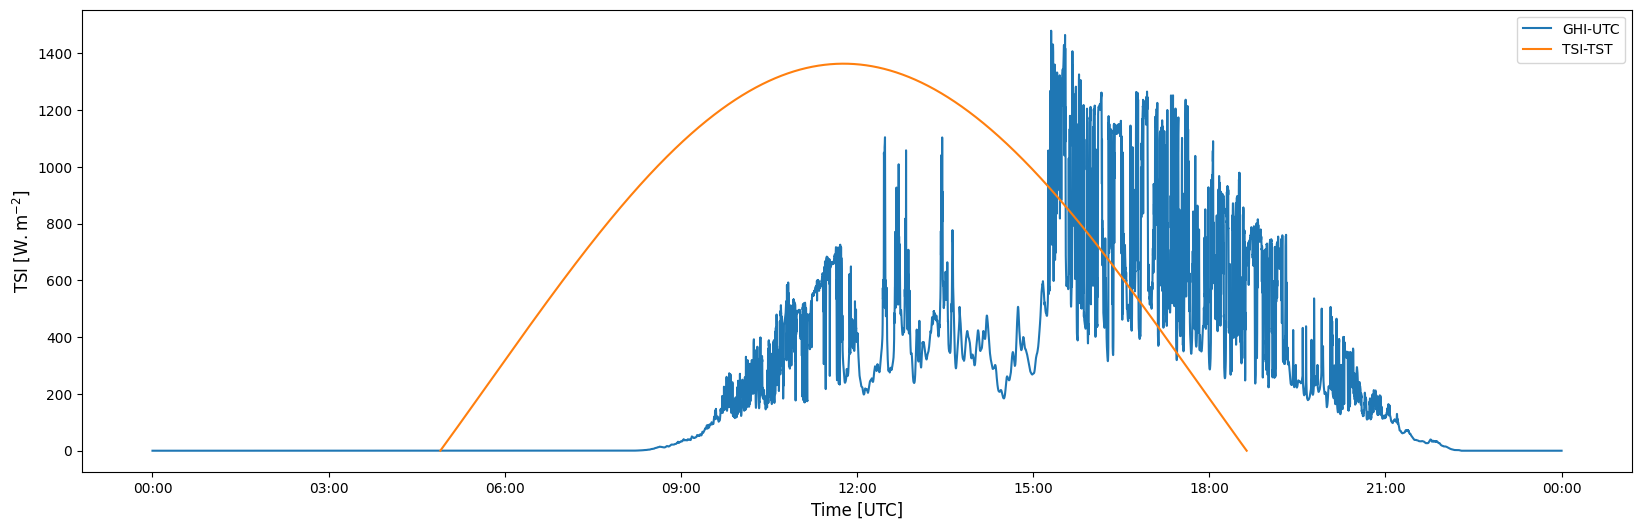

In [327]:
fig, ax = plt.subplots()

ax.plot(df['tt'], df['pp'], label='GHI-UTC')
ax.set_xlabel('Time [UTC]', fontsize=12)
ax.set_ylabel(r'TSI [$\mathrm{W.m^{-2}}$]', fontsize=12)
ax.plot(mydf['tst'], mydf['tsi'], label='TSI-TST')
formatter = DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
ax.legend(loc='best')
plt.show()

fig.savefig('/content/sample_data/'+ 'tsi_tst.png',   dpi=600, bbox_inches='tight')

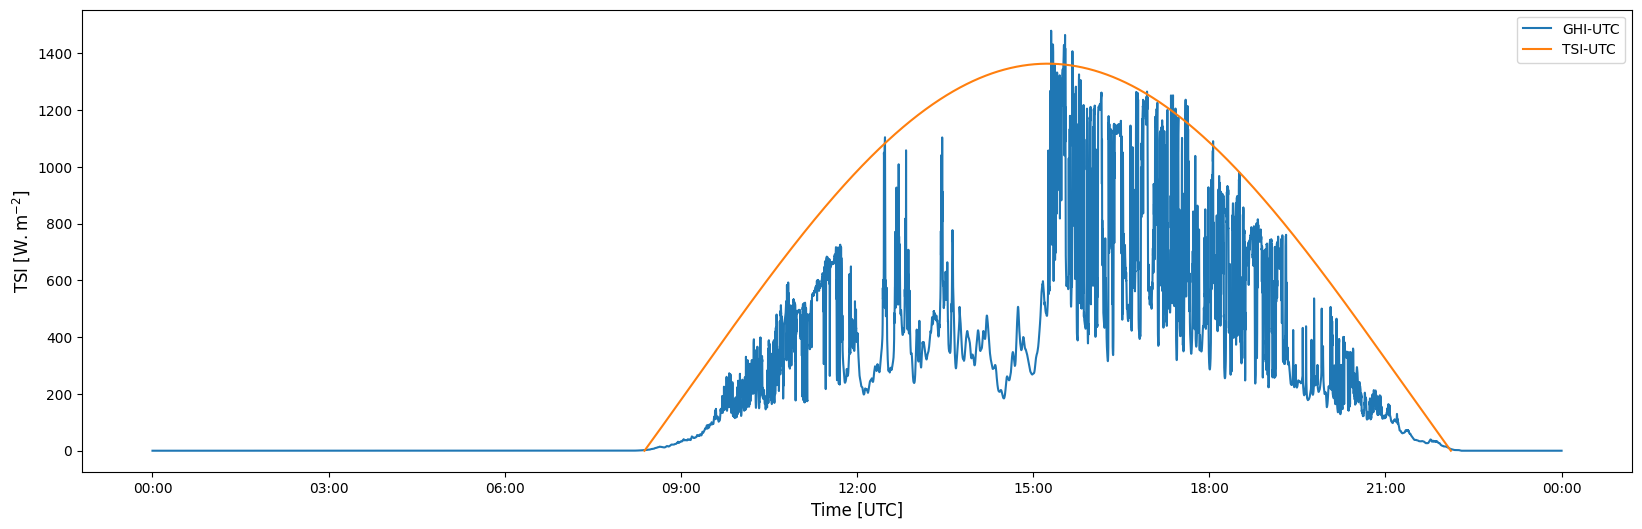

In [328]:
fig, ax = plt.subplots()

ax.plot(df['tt'], df['pp'], label='GHI-UTC')
ax.set_xlabel('Time [UTC]', fontsize=12)
ax.set_ylabel(r'TSI [$\mathrm{W.m^{-2}}$]', fontsize=12)
ax.plot(mydf['utc'], mydf['tsi'], label='TSI-UTC')
formatter = DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
ax.legend(loc='best')
plt.show()

fig.savefig('/content/sample_data/'+ 'tsi_utc.png',  dpi=600, bbox_inches='tight')
